In [4]:
import os
import sys

# Make sure Python can see the parent folder (where src/ lives)
sys.path.append(os.path.abspath(".."))

import torch
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

from src.config import Config
from src.data import create_dataloaders
from src.model import SentimentClassifier
from src.train import train_model
from src.evaluate import evaluate_on_test

In [5]:
# Load the IMDB dataset from Hugging Face
raw_dataset = load_dataset("imdb")

# Convert train and test splits to pandas DataFrames for quick inspection
df_train = raw_dataset["train"].to_pandas()
df_test = raw_dataset["test"].to_pandas()

# Show the first 5 rows of the training set
df_train.head()


Generating unsupervised split: 100%|██████████| 50000/50000 [00:00<00:00, 196776.00 examples/s]


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


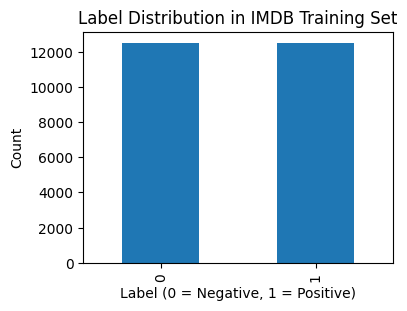

In [6]:
df_train["label"].value_counts().plot(kind="bar", figsize=(4,3))
plt.title("Label Distribution in IMDB Training Set")
plt.xlabel("Label (0 = Negative, 1 = Positive)")
plt.ylabel("Count")
plt.show()


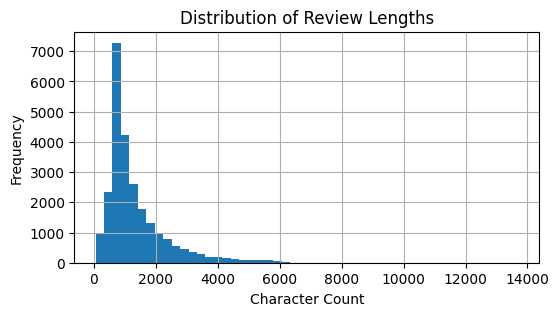

In [7]:
df_train["text_length"] = df_train["text"].str.len()

df_train["text_length"].hist(bins=50, figsize=(6,3))
plt.title("Distribution of Review Lengths")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.show()


In [8]:
#The IMDB dataset contains 25,000 training reviews and 25,000 test reviews, evenly split between negative (0) and positive (1) labels.

#The label distribution is perfectly balanced, which means we do not need to apply any re-sampling.

#Review text lengths vary significantly, with many reviews between 500 and 2,000 characters.

#The dataset does not require manual cleaning; tokenization and truncation handled by the transformer tokenizer are sufficient.

In [9]:
cfg = Config()
train_loader, val_loader, test_loader = create_dataloaders(cfg)

len(train_loader), len(val_loader), len(test_loader)


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(1250, 313, 1563)

In [10]:
model = SentimentClassifier(cfg)
model


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


SentimentClassifier(
  (backbone): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [11]:
cfg = Config()          # uses the full config (max_len, batch_size, epochs)
model = train_model(cfg)


Epoch 1/3 - Train Loss: 0.2726, Train Acc: 0.8853 - Val Loss: 0.2237, Val Acc: 0.9088


Epoch 2/3 - Train Loss: 0.1452, Train Acc: 0.9485 - Val Loss: 0.2669, Val Acc: 0.9022


Epoch 3/3 - Train Loss: 0.0719, Train Acc: 0.9752 - Val Loss: 0.2682, Val Acc: 0.9184


In [12]:
results = evaluate_on_test(cfg)
results["report"]


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'0': {'precision': 0.9371714431066644,
  'recall': 0.88424,
  'f1-score': 0.9099366098625175,
  'support': 12500.0},
 '1': {'precision': 0.8904285930637589,
  'recall': 0.94072,
  'f1-score': 0.9148836847428616,
  'support': 12500.0},
 'accuracy': 0.91248,
 'macro avg': {'precision': 0.9138000180852117,
  'recall': 0.91248,
  'f1-score': 0.9124101473026895,
  'support': 25000.0},
 'weighted avg': {'precision': 0.9138000180852116,
  'recall': 0.91248,
  'f1-score': 0.9124101473026895,
  'support': 25000.0}}

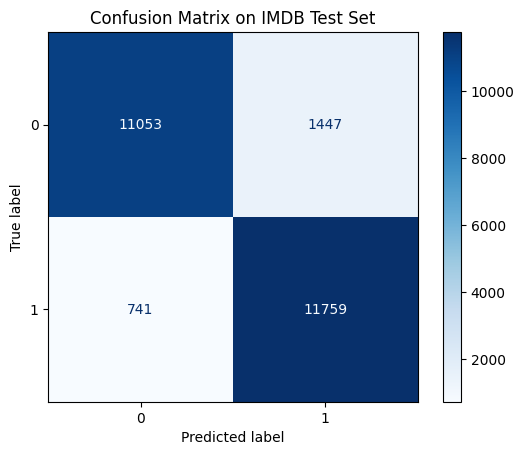

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = results["confusion_matrix"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on IMDB Test Set")
plt.show()


In [14]:
## Conclusion

In this project, I fine-tuned a BERT-based transformer model to classify IMDB movie reviews as positive or negative.

After tokenizing the text and creating PyTorch DataLoaders, the model was trained for three epochs on the full training set. The final validation accuracy reached approximately **91.8%**, and the test accuracy reached about **91.2%**.

Both classes are handled well: negative reviews (label 0) achieve high precision (~0.94) and good recall (~0.88), while positive reviews (label 1) show strong recall (~0.94) and precision (~0.89). The confusion matrix confirms that most errors are isolated misclassifications rather than a strong bias toward one label.

Potential improvements could include:
- Trying alternative transformer backbones such as DistilBERT or RoBERTa.
- Adding learning rate scheduling or more training epochs with early stopping.
- Experimenting with different maximum sequence lengths or batch sizes.

Overall, the model provides strong performance on the IMDB sentiment analysis task and demonstrates that transformer-based architectures are very effective for text classification.


SyntaxError: invalid syntax (1903100034.py, line 3)